In [1]:
import pandas as pd

In [9]:
# -------------------------------
# 2️⃣ Load autoencoder CSVs (clusters 0-6) and concatenate
# -------------------------------
ae_dfs = []
for i in range(6):
    path = f'/home/ranushi/test/Anomaly DetectionMethod/anomalous_high_energy_households_cluster_2{i}.csv'
    df = pd.read_csv(path)
    df = df[['household_ID', 'cluster']]
    ae_dfs.append(df)

ae_df = pd.concat(ae_dfs, ignore_index=True)

In [10]:
appliance_age = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/wave_1/household_appliance_specifications_202509020921.csv')

/tmp/ipykernel_13574/2973607930.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  appliance_age = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/wave_1/household_appliance_specifications_202509020921.csv')


In [11]:
appliance_age = appliance_age[['household_id','appliance_name','no_of_appliances','purchased_time1',
                              'purchased_time2','purchased_time3','purchased_time4']]

In [12]:
df = appliance_age.copy()

In [13]:
import pandas as pd
import numpy as np

# Define order of appliance age (older = larger number)
age_order = {
    'Within the last 1 year': 1,
    'Within the last 1-5 years': 2,
    'Wthin the last 1-5 years': 2,     # fix typo version
    'Within the last 5-10 years': 3,
    'Wthin the last 5-10 years': 3,    # fix typo version
    'More than 10 years ago': 4
}

# Columns to check
purchased_cols = ['purchased_time1', 'purchased_time2', 'purchased_time3', 'purchased_time4']

# Convert categories to numeric according to hierarchy
df_numeric = df[purchased_cols].apply(lambda col: col.map(age_order))

# Find the oldest (maximum numeric value across columns)
df['appliance_age_code'] = df_numeric.max(axis=1, skipna=True)

# Map numeric code back to category name
reverse_age_order = {v: k for k, v in age_order.items()}
df['appliance_age'] = df['appliance_age_code'].map(reverse_age_order)

# Keep only the required columns
result = df[['household_id', 'appliance_name', 'appliance_age']].dropna(subset=['appliance_age']).reset_index(drop=True)

print(result.head())

  household_id   appliance_name              appliance_age
0       ID0430        Microwave     More than 10 years ago
1       ID0430      Rice cooker  Wthin the last 5-10 years
2       ID0430  Electric Kettle     More than 10 years ago
3       ID0528     Refrigerator     More than 10 years ago
4       ID0528      Rice cooker     Within the last 1 year


In [14]:
import pandas as pd
import os
import glob

# Directory path
dir_path = '/home/ranushi/test/Anomaly DetectionMethod/15min_interval'

# Get all CSV files in the directory
csv_files = glob.glob(os.path.join(dir_path, '*.csv'))

# List to store dataframes
dfs = []

# Read each CSV file
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all dataframes
combined_df = pd.concat(dfs, ignore_index=True)

# Calculate average powerfactor for each household
avg_powerfactor = combined_df.groupby('household_ID')['powerfactor'].mean().reset_index()
avg_powerfactor.columns = ['household_ID', 'average_powerfactor']

# Display the result
print(avg_powerfactor)

     household_ID  average_powerfactor
0          ID0013             0.754472
1          ID0018             0.205128
2          ID0041            -0.001664
3          ID0043             0.220554
4          ID0052             0.869455
...           ...                  ...
2933       ID5571             0.946570
2934       ID5572             0.121005
2935       ID5573             0.710816
2936       ID5574             0.553514
2937       ID5575             0.245074

[2938 rows x 2 columns]


In [15]:
age_powerfactor = pd.merge(result,avg_powerfactor, left_on='household_id', right_on='household_ID', how='inner')

In [17]:
age_powerfactor

,household_id,appliance_name,appliance_age,household_ID,average_powerfactor
0,ID0886,Rice cooker,Wthin the last 5-10 years,ID0886,0.914335
1,ID0886,Washing Machine,More than 10 years ago,ID0886,0.914335
2,ID0886,Electric Iron including electric steam iron,More than 10 years ago,ID0886,0.914335
3,ID0886,Laptops,More than 10 years ago,ID0886,0.914335
4,ID0041,Rice cooker,Wthin the last 5-10 years,ID0041,-0.001664
...,...,...,...,...,...
4367,ID2272,Washing Machine,Wthin the last 5-10 years,ID2272,0.962718
4368,ID2272,Electric Iron including electric steam iron,Wthin the last 5-10 years,ID2272,0.962718
4369,ID3144,Electric Iron including electric steam iron,More than 10 years ago,ID3144,0.677572
4370,ID3142,Rice cooker,More than 10 years ago,ID3142,0.809876


In [18]:
filtered_data = age_powerfactor[
    (age_powerfactor['appliance_age'] == 'More than 10 years ago') & 
    (age_powerfactor['average_powerfactor'] < 0.75) &
    (age_powerfactor['average_powerfactor'].notna())
]

In [19]:
# Find intersection of household_IDs
common_households = set(filtered_data['household_id']).intersection(set(ae_df['household_ID']))

# Convert to DataFrame if you want to see or save it
intersection_df = pd.DataFrame({'household_ID': list(common_households)})

# Display results
print(f"Number of common households: {len(intersection_df)}")
print(intersection_df.head())

Number of common households: 50
  household_ID
0       ID1019
1       ID0533
2       ID2077
3       ID0232
4       ID2408


In [22]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import glob

# ======================================================
# 1️⃣ Load the ground truth anomalies (filtered_data)
# ======================================================
# Assuming filtered_data is already a DataFrame
true_anomalies = set(filtered_data['household_ID'].unique())
# ======================================================
# 2️⃣ Load predicted anomalies
# ======================================================
#similar_csv = '/home/ranushi/test/Anomaly DetectionMethod/similar_usage_high_energy_households3.csv'
#predicted_anomalies_df = pd.read_csv(similar_csv)
predicted_anomalies = set(ae_df['household_ID'].unique())
# ======================================================
# 3️⃣ Load all households from 6-hour interval files
# ======================================================
folder_path = '/home/ranushi/test/Anomaly DetectionMethod/6hour_interval'
all_files = glob.glob(os.path.join(folder_path, '*.csv'))

all_households = set()
for file in all_files:
    df = pd.read_csv(file)
    if 'household_ID' in df.columns:
        all_households.update(df['household_ID'].unique())
    else:
        print(f"⚠️ Skipping {file}, no 'household_ID' column found.")

# ======================================================
# 4️⃣ Identify normal households (not in ground truth anomalies)
# ======================================================
normal_households = all_households - true_anomalies


/tmp/ipykernel_13574/3814418572.py:26: DtypeWarning: Columns (9,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_13574/3814418572.py:26: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_13574/3814418572.py:26: DtypeWarning: Columns (14,25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_13574/3814418572.py:26: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


In [23]:
# ======================================================
# 5️⃣ Build labels for confusion matrix
# ======================================================
y_true = []
y_pred = []

for hh in all_households:
    true_label = 1 if hh in true_anomalies else 0
    pred_label = 1 if hh in predicted_anomalies else 0
    y_true.append(true_label)
    y_pred.append(pred_label)

✅ Confusion Matrix:
                   Predicted: Anomalous  Predicted: Normal
Actual: Anomalous                    50                155
Actual: Normal                      198               2547

Metrics Summary:
True Positives (TP): 50
False Negatives (FN): 155
False Positives (FP): 198
True Negatives (TN): 2547


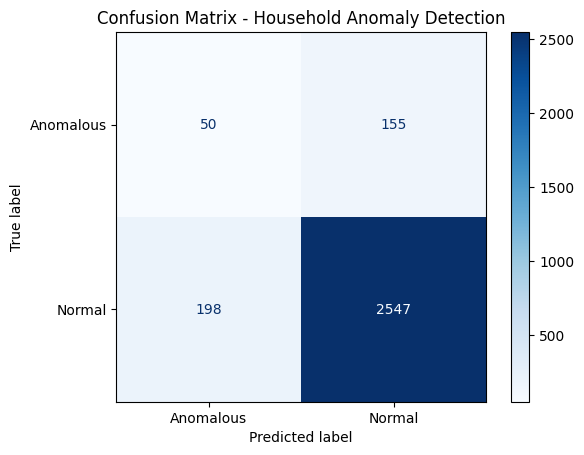

In [24]:

# ======================================================
# 6️⃣ Compute confusion matrix
# ======================================================
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

# Order: [[TP, FN], [FP, TN]]
tp, fn, fp, tn = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

print("✅ Confusion Matrix:")
print(pd.DataFrame(cm,
                   index=['Actual: Anomalous', 'Actual: Normal'],
                   columns=['Predicted: Anomalous', 'Predicted: Normal']))
print("\nMetrics Summary:")
print(f"True Positives (TP): {tp}")
print(f"False Negatives (FN): {fn}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")

# ======================================================
# 7️⃣ Visualize confusion matrix
# ======================================================
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Anomalous', 'Normal'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Household Anomaly Detection")
plt.show()

In [25]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    classification_report
)

# ======================================================
# 6️⃣.1 Compute full performance metrics
# ======================================================

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Classification report
report = classification_report(
    y_true,
    y_pred,
    target_names=["Normal", "Anomalous"],
    digits=3
)

# Print results
print("\n==================== METRICS SUMMARY ====================")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1 Score : {f1:.3f}")
print("==========================================================")
print("\nDetailed Classification Report:")
print(report)


==================== METRICS SUMMARY ====================
Accuracy : 0.880
Precision: 0.202
Recall   : 0.244
F1 Score : 0.221

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal      0.943     0.928     0.935      2745
   Anomalous      0.202     0.244     0.221       205

    accuracy                          0.880      2950
   macro avg      0.572     0.586     0.578      2950
weighted avg      0.891     0.880     0.886      2950



##  AC,Ref

In [26]:
df = appliance_age.copy()

In [27]:
import pandas as pd
import numpy as np

# Define order of appliance age (older = larger number)
age_order = {
    'Within the last 1 year': 1,
    'Within the last 1-5 years': 2,
    'Wthin the last 1-5 years': 2,     # fix typo version
    'Within the last 5-10 years': 3,
    'Wthin the last 5-10 years': 3,    # fix typo version
    'More than 10 years ago': 4
}

# Columns to check
purchased_cols = ['purchased_time1', 'purchased_time2', 'purchased_time3', 'purchased_time4']

# Convert categories to numeric according to hierarchy
df_numeric = df[purchased_cols].apply(lambda col: col.map(age_order))

# Find the oldest (maximum numeric value across columns)
df['appliance_age_code'] = df_numeric.max(axis=1, skipna=True)

# Map numeric code back to category name
reverse_age_order = {v: k for k, v in age_order.items()}
df['appliance_age'] = df['appliance_age_code'].map(reverse_age_order)

# Keep only the required columns
result = df[['household_id', 'appliance_name', 'appliance_age']].dropna(subset=['appliance_age']).reset_index(drop=True)

print(result.head())

  household_id   appliance_name              appliance_age
0       ID0430        Microwave     More than 10 years ago
1       ID0430      Rice cooker  Wthin the last 5-10 years
2       ID0430  Electric Kettle     More than 10 years ago
3       ID0528     Refrigerator     More than 10 years ago
4       ID0528      Rice cooker     Within the last 1 year


#### AC, REF More than 5 years

In [28]:
# Define target appliances
target_appliances = ['Air Conditioner', 'Refrigerator']

# Define old or unknown age categories
old_or_unknown = [
    'Within the last 5-10 years',
    'Wthin the last 5-10 years',
    'More than 10 years ago'
]

# Filter rows for those appliances and ages (or NaN)
filtered1 = result[
    (result['appliance_name'].isin(target_appliances)) &
    (result['appliance_age'].isin(old_or_unknown) | result['appliance_age'].isna())
]

# Get unique household IDs that meet the condition
households_to_flag1 = filtered1['household_id'].unique()

In [29]:
households_to_flag1 = pd.DataFrame(households_to_flag1, columns=['household_id'])
households_to_flag1

,household_id
0,ID0528
1,ID2328
2,ID1146
3,ID2755
4,ID2663
...,...
1737,ID2496
1738,ID0320
1739,ID0373
1740,ID0160


In [31]:
# Find intersection of household_IDs
common_households = set(households_to_flag1['household_id']).intersection(set(ae_df['household_ID']))

# Convert to DataFrame if you want to see or save it
intersection_df = pd.DataFrame({'household_ID': list(common_households)})

# Display results
print(f"Number of common households: {len(intersection_df)}")
print(intersection_df.head())

Number of common households: 116
  household_ID
0       ID3799
1       ID1680
2       ID0497
3       ID3213
4       ID0938


In [32]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import glob

# ======================================================
# 1️⃣ Load the ground truth anomalies (filtered_data)
# ======================================================
# Assuming filtered_data is already a DataFrame
true_anomalies = set(households_to_flag1['household_id'].unique())

In [33]:

predicted_anomalies = set(ae_df['household_ID'].unique())

In [34]:
# ======================================================
# 3️⃣ Load all households from 6-hour interval files
# ======================================================
folder_path = '/home/ranushi/test/Anomaly DetectionMethod/6hour_interval'
all_files = glob.glob(os.path.join(folder_path, '*.csv'))

all_households = set()
for file in all_files:
    df = pd.read_csv(file)
    if 'household_ID' in df.columns:
        all_households.update(df['household_ID'].unique())
    else:
        print(f"⚠️ Skipping {file}, no 'household_ID' column found.")

# ======================================================
# 4️⃣ Identify normal households (not in ground truth anomalies)
# ======================================================
normal_households = all_households - true_anomalies

/tmp/ipykernel_13574/4074882391.py:9: DtypeWarning: Columns (9,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_13574/4074882391.py:9: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_13574/4074882391.py:9: DtypeWarning: Columns (14,25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_13574/4074882391.py:9: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


In [35]:
# ======================================================
# 5️⃣ Build labels for confusion matrix
# ======================================================
y_true = []
y_pred = []

for hh in all_households:
    true_label = 1 if hh in true_anomalies else 0
    pred_label = 1 if hh in predicted_anomalies else 0
    y_true.append(true_label)
    y_pred.append(pred_label)

✅ Confusion Matrix:
                   Predicted: Anomalous  Predicted: Normal
Actual: Anomalous                   116                522
Actual: Normal                      132               2180

Metrics Summary:
True Positives (TP): 116
False Negatives (FN): 522
False Positives (FP): 132
True Negatives (TN): 2180


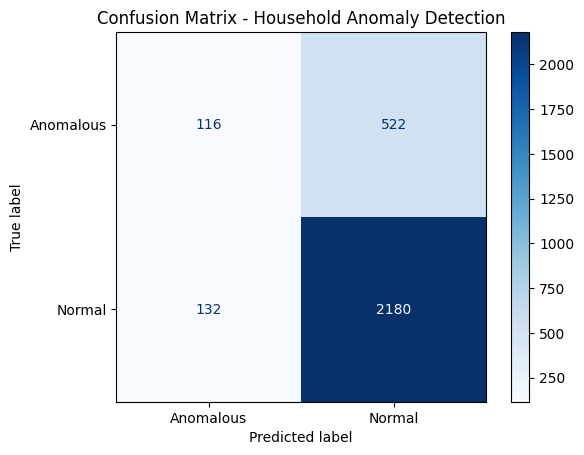

In [36]:

# ======================================================
# 6️⃣ Compute confusion matrix
# ======================================================
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

# Order: [[TP, FN], [FP, TN]]
tp, fn, fp, tn = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

print("✅ Confusion Matrix:")
print(pd.DataFrame(cm,
                   index=['Actual: Anomalous', 'Actual: Normal'],
                   columns=['Predicted: Anomalous', 'Predicted: Normal']))
print("\nMetrics Summary:")
print(f"True Positives (TP): {tp}")
print(f"False Negatives (FN): {fn}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")

# ======================================================
# 7️⃣ Visualize confusion matrix
# ======================================================
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Anomalous', 'Normal'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Household Anomaly Detection")
plt.show()

In [37]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    classification_report
)

# ======================================================
# 6️⃣.1 Compute full performance metrics
# ======================================================

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Classification report
report = classification_report(
    y_true,
    y_pred,
    target_names=["Normal", "Anomalous"],
    digits=3
)

# Print results
print("\n==================== METRICS SUMMARY ====================")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1 Score : {f1:.3f}")
print("==========================================================")
print("\nDetailed Classification Report:")
print(report)


==================== METRICS SUMMARY ====================
Accuracy : 0.778
Precision: 0.468
Recall   : 0.182
F1 Score : 0.262

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal      0.807     0.943     0.870      2312
   Anomalous      0.468     0.182     0.262       638

    accuracy                          0.778      2950
   macro avg      0.637     0.562     0.566      2950
weighted avg      0.733     0.778     0.738      2950



#### AC, REF more than 10 years

In [38]:
# Define target appliances
target_appliances = ['Air Conditioner', 'Refrigerator']

# Define old or unknown age categories
old_or_unknown = [
    'More than 10 years ago'
]

# Filter rows for those appliances and ages (or NaN)
filtered2 = result[
    (result['appliance_name'].isin(target_appliances)) &
    (result['appliance_age'].isin(old_or_unknown) | result['appliance_age'].isna())
]

# Get unique household IDs that meet the condition
households_to_flag2 = filtered2['household_id'].unique()

In [39]:
households_to_flag2 = pd.DataFrame(households_to_flag2, columns=['household_id'])
households_to_flag2

,household_id
0,ID0528
1,ID1146
2,ID2663
3,ID0016
4,ID0055
...,...
891,ID3731
892,ID2272
893,ID1349
894,ID0320


In [40]:
# Find intersection of household_IDs
common_households = set(households_to_flag2['household_id']).intersection(set(ae_df['household_ID']))

# Convert to DataFrame if you want to see or save it
intersection_df = pd.DataFrame({'household_ID': list(common_households)})

# Display results
print(f"Number of common households: {len(intersection_df)}")
print(intersection_df.head())

Number of common households: 60
  household_ID
0       ID1019
1       ID3799
2       ID2077
3       ID0796
4       ID0701


In [41]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import glob

# ======================================================
# 1️⃣ Load the ground truth anomalies (filtered_data)
# ======================================================
# Assuming filtered_data is already a DataFrame
true_anomalies = set(households_to_flag2['household_id'].unique())

In [43]:
# ======================================================
# 4️⃣ Identify normal households (not in ground truth anomalies)
# ======================================================
normal_households = all_households - true_anomalies
# ======================================================
# 5️⃣ Build labels for confusion matrix
# ======================================================
y_true = []
y_pred = []

for hh in all_households:
    true_label = 1 if hh in true_anomalies else 0
    pred_label = 1 if hh in predicted_anomalies else 0
    y_true.append(true_label)
    y_pred.append(pred_label)

✅ Confusion Matrix:
                   Predicted: Anomalous  Predicted: Normal
Actual: Anomalous                    60                266
Actual: Normal                      188               2436

Metrics Summary:
True Positives (TP): 60
False Negatives (FN): 266
False Positives (FP): 188
True Negatives (TN): 2436


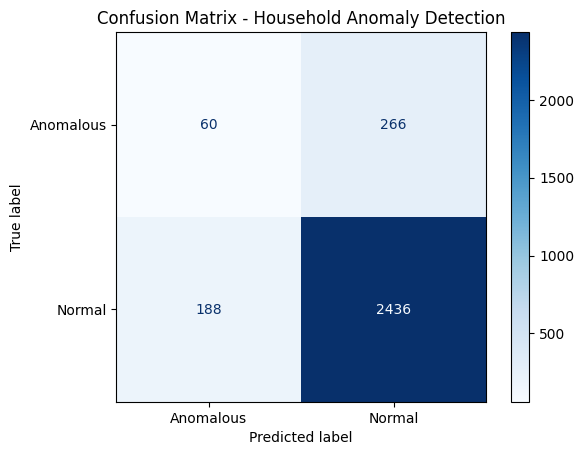

In [44]:

# ======================================================
# 6️⃣ Compute confusion matrix
# ======================================================
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

# Order: [[TP, FN], [FP, TN]]
tp, fn, fp, tn = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

print("✅ Confusion Matrix:")
print(pd.DataFrame(cm,
                   index=['Actual: Anomalous', 'Actual: Normal'],
                   columns=['Predicted: Anomalous', 'Predicted: Normal']))
print("\nMetrics Summary:")
print(f"True Positives (TP): {tp}")
print(f"False Negatives (FN): {fn}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")

# ======================================================
# 7️⃣ Visualize confusion matrix
# ======================================================
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Anomalous', 'Normal'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Household Anomaly Detection")
plt.show()

In [45]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    classification_report
)

# ======================================================
# 6️⃣.1 Compute full performance metrics
# ======================================================

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Classification report
report = classification_report(
    y_true,
    y_pred,
    target_names=["Normal", "Anomalous"],
    digits=3
)

# Print results
print("\n==================== METRICS SUMMARY ====================")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1 Score : {f1:.3f}")
print("==========================================================")
print("\nDetailed Classification Report:")
print(report)


==================== METRICS SUMMARY ====================
Accuracy : 0.846
Precision: 0.242
Recall   : 0.184
F1 Score : 0.209

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal      0.902     0.928     0.915      2624
   Anomalous      0.242     0.184     0.209       326

    accuracy                          0.846      2950
   macro avg      0.572     0.556     0.562      2950
weighted avg      0.829     0.846     0.837      2950



In [46]:
import pandas as pd

# assuming your dataframe is called df

# clean up common spelling variations (optional but useful)
result['appliance_age'] = result['appliance_age'].replace({
    'Wthin the last 5-10 years': 'Within the last 5-10 years'
})

# condition for Air Conditioners
cond_aircon = (
    (result['appliance_name'].str.lower().str.strip() == 'air conditioner') &
    (result['appliance_age'].isin([
        'Within the last 5-10 years',
        'More than 10 years ago'
    ]))
)

# condition for Refrigerator
cond_fridge = (
    (result['appliance_name'].str.lower().str.strip() == 'refrigerator') &
    (result['appliance_age'] == 'More than 10 years ago')
)

# combine both conditions
filtered_df3 = result[cond_aircon | cond_fridge]

# if you want only unique households that meet the criteria:
households_filtered3 = filtered_df3['household_id'].unique()

# # optionally filter original df to show all appliances of those households
# households_df3 = result[result['household_id'].isin(households_filtered3)]

In [47]:
households_filtered3 = pd.DataFrame(households_filtered3, columns=['household_id'])

In [48]:
# Find intersection of household_IDs
common_households = set(households_filtered3['household_id']).intersection(set(ae_df['household_ID']))

# Convert to DataFrame if you want to see or save it
intersection_df = pd.DataFrame({'household_ID': list(common_households)})

# Display results
print(f"Number of common households: {len(intersection_df)}")
print(intersection_df.head())

Number of common households: 60
  household_ID
0       ID1019
1       ID3799
2       ID2077
3       ID0796
4       ID0701


In [49]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import glob

# ======================================================
# 1️⃣ Load the ground truth anomalies (filtered_data)
# ======================================================
# Assuming filtered_data is already a DataFrame
true_anomalies = set(households_filtered3['household_id'].unique())
# ======================================================
# 4️⃣ Identify normal households (not in ground truth anomalies)
# ======================================================
normal_households = all_households - true_anomalies
# ======================================================
# 5️⃣ Build labels for confusion matrix
# ======================================================
y_true = []
y_pred = []

for hh in all_households:
    true_label = 1 if hh in true_anomalies else 0
    pred_label = 1 if hh in predicted_anomalies else 0
    y_true.append(true_label)
    y_pred.append(pred_label)

✅ Confusion Matrix:
                   Predicted: Anomalous  Predicted: Normal
Actual: Anomalous                    60                267
Actual: Normal                      188               2435

Metrics Summary:
True Positives (TP): 60
False Negatives (FN): 267
False Positives (FP): 188
True Negatives (TN): 2435


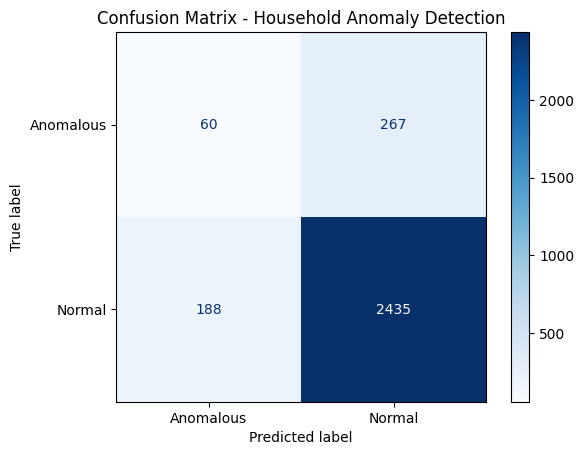

In [50]:

# ======================================================
# 6️⃣ Compute confusion matrix
# ======================================================
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

# Order: [[TP, FN], [FP, TN]]
tp, fn, fp, tn = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

print("✅ Confusion Matrix:")
print(pd.DataFrame(cm,
                   index=['Actual: Anomalous', 'Actual: Normal'],
                   columns=['Predicted: Anomalous', 'Predicted: Normal']))
print("\nMetrics Summary:")
print(f"True Positives (TP): {tp}")
print(f"False Negatives (FN): {fn}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")

# ======================================================
# 7️⃣ Visualize confusion matrix
# ======================================================
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Anomalous', 'Normal'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Household Anomaly Detection")
plt.show()

In [51]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    classification_report
)

# ======================================================
# 6️⃣.1 Compute full performance metrics
# ======================================================

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Classification report
report = classification_report(
    y_true,
    y_pred,
    target_names=["Normal", "Anomalous"],
    digits=3
)

# Print results
print("\n==================== METRICS SUMMARY ====================")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1 Score : {f1:.3f}")
print("==========================================================")
print("\nDetailed Classification Report:")
print(report)


==================== METRICS SUMMARY ====================
Accuracy : 0.846
Precision: 0.242
Recall   : 0.183
F1 Score : 0.209

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal      0.901     0.928     0.915      2623
   Anomalous      0.242     0.183     0.209       327

    accuracy                          0.846      2950
   macro avg      0.572     0.556     0.562      2950
weighted avg      0.828     0.846     0.836      2950



#### ac>10,ref>5

In [52]:
import pandas as pd

# assuming your dataframe is called df

# clean up common spelling variations (optional but useful)
result['appliance_age'] = result['appliance_age'].replace({
    'Wthin the last 5-10 years': 'Within the last 5-10 years'
})

# condition for Air Conditioners
cond_aircon = (
    (result['appliance_name'].str.lower().str.strip() == 'air conditioner') &
    (result['appliance_age'].isin([
        'More than 10 years ago'
    ]))
)

# condition for Refrigerator
cond_fridge = (
    (result['appliance_name'].str.lower().str.strip() == 'refrigerator') &
    (result['appliance_age'].isin(['More than 10 years ago','Within the last 5-10 years']))
)

# combine both conditions
filtered_df4 = result[cond_aircon | cond_fridge]

# if you want only unique households that meet the criteria:
households_filtered4 = filtered_df4['household_id'].unique()

In [53]:
households_filtered4 = pd.DataFrame(households_filtered4, columns=['household_id'])

In [54]:
# Find intersection of household_IDs
common_households = set(households_filtered4['household_id']).intersection(set(ae_df['household_ID']))

# Convert to DataFrame if you want to see or save it
intersection_df = pd.DataFrame({'household_ID': list(common_households)})

# Display results
print(f"Number of common households: {len(intersection_df)}")
print(intersection_df.head())

Number of common households: 116
  household_ID
0       ID3799
1       ID1680
2       ID0497
3       ID3213
4       ID0938


✅ Confusion Matrix:
                   Predicted: Anomalous  Predicted: Normal
Actual: Anomalous                   116                521
Actual: Normal                      132               2181

Metrics Summary:
True Positives (TP): 116
False Negatives (FN): 521
False Positives (FP): 132
True Negatives (TN): 2181


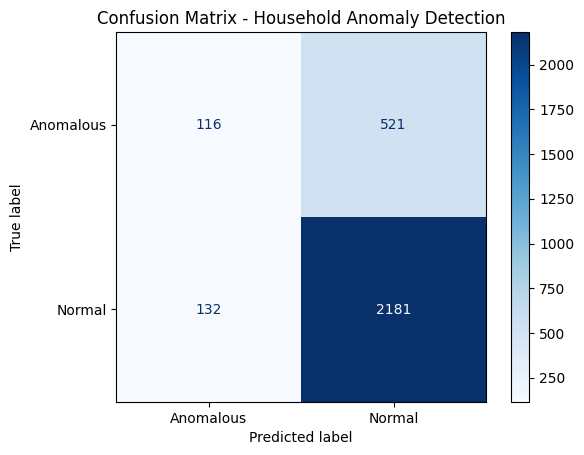

In [55]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import glob

# ======================================================
# 1️⃣ Load the ground truth anomalies (filtered_data)
# ======================================================
# Assuming filtered_data is already a DataFrame
true_anomalies = set(households_filtered4['household_id'].unique())
# ======================================================
# 4️⃣ Identify normal households (not in ground truth anomalies)
# ======================================================
normal_households = all_households - true_anomalies

# ======================================================
# 5️⃣ Build labels for confusion matrix
# ======================================================
y_true = []
y_pred = []

for hh in all_households:
    true_label = 1 if hh in true_anomalies else 0
    pred_label = 1 if hh in predicted_anomalies else 0
    y_true.append(true_label)
    y_pred.append(pred_label)


# ======================================================
# 6️⃣ Compute confusion matrix
# ======================================================
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

# Order: [[TP, FN], [FP, TN]]
tp, fn, fp, tn = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

print("✅ Confusion Matrix:")
print(pd.DataFrame(cm,
                   index=['Actual: Anomalous', 'Actual: Normal'],
                   columns=['Predicted: Anomalous', 'Predicted: Normal']))
print("\nMetrics Summary:")
print(f"True Positives (TP): {tp}")
print(f"False Negatives (FN): {fn}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")

# ======================================================
# 7️⃣ Visualize confusion matrix
# ======================================================
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Anomalous', 'Normal'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Household Anomaly Detection")
plt.show()


In [56]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    classification_report
)

# ======================================================
# 6️⃣.1 Compute full performance metrics
# ======================================================

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Classification report
report = classification_report(
    y_true,
    y_pred,
    target_names=["Normal", "Anomalous"],
    digits=3
)

# Print results
print("\n==================== METRICS SUMMARY ====================")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1 Score : {f1:.3f}")
print("==========================================================")
print("\nDetailed Classification Report:")
print(report)


==================== METRICS SUMMARY ====================
Accuracy : 0.779
Precision: 0.468
Recall   : 0.182
F1 Score : 0.262

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal      0.807     0.943     0.870      2313
   Anomalous      0.468     0.182     0.262       637

    accuracy                          0.779      2950
   macro avg      0.637     0.563     0.566      2950
weighted avg      0.734     0.779     0.739      2950



In [57]:
survey_data = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/wave_1/w1_household_information_and_history.csv')

In [58]:
survey_data = survey_data[['household_ID', 'built_year_of_the_house']]
survey_data['built_year_of_the_house'].value_counts()

built_year_of_the_house
2000-2009                918
2010-2019                758
Before 1980              740
1990-1999                615
1980-1989                482
Don't know               325
In 2020 or After 2020    225
Name: count, dtype: int64

In [59]:
# assuming your dataframe is called survey_data

target_years = ['Before 1980', '1990-1999', '1980-1989', "Don't know"]

filtered_survey = survey_data[survey_data['built_year_of_the_house'].isin(target_years)]

# if you just want the IDs of those households:
households_filtered5 = filtered_survey['household_ID'].unique()


In [60]:
households_filtered5 = pd.DataFrame(households_filtered5, columns=['household_ID'])
households_filtered5

,household_ID
0,ID0002
1,ID0003
2,ID0010
3,ID0013
4,ID0019
...,...
2157,ID4054
2158,ID4057
2159,ID4058
2160,ID4060


In [61]:
# Find intersection of household_IDs
common_households = set(households_filtered5['household_ID']).intersection(set(ae_df['household_ID']))

# Convert to DataFrame if you want to see or save it
intersection_df = pd.DataFrame({'household_ID': list(common_households)})

# Display results
print(f"Number of common households: {len(intersection_df)}")
print(intersection_df.head())

Number of common households: 122
  household_ID
0       ID3297
1       ID3799
2       ID1670
3       ID1430
4       ID3213


In [62]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import glob

# ======================================================
# 1️⃣ Load the ground truth anomalies (filtered_data)
# ======================================================
# Assuming filtered_data is already a DataFrame
true_anomalies = set(households_filtered5['household_ID'].unique())

✅ Confusion Matrix:
                   Predicted: Anomalous  Predicted: Normal
Actual: Anomalous                   122                651
Actual: Normal                      126               2051

Metrics Summary:
True Positives (TP): 122
False Negatives (FN): 651
False Positives (FP): 126
True Negatives (TN): 2051


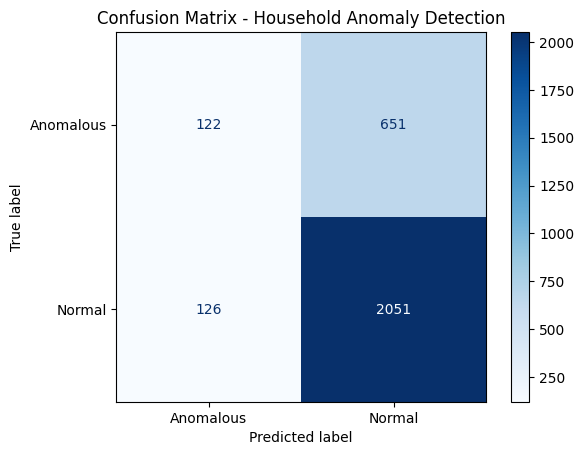

In [63]:
# ======================================================
# 4️⃣ Identify normal households (not in ground truth anomalies)
# ======================================================
normal_households = all_households - true_anomalies
# ======================================================
# 5️⃣ Build labels for confusion matrix
# ======================================================
y_true = []
y_pred = []

for hh in all_households:
    true_label = 1 if hh in true_anomalies else 0
    pred_label = 1 if hh in predicted_anomalies else 0
    y_true.append(true_label)
    y_pred.append(pred_label)


# ======================================================
# 6️⃣ Compute confusion matrix
# ======================================================
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

# Order: [[TP, FN], [FP, TN]]
tp, fn, fp, tn = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

print("✅ Confusion Matrix:")
print(pd.DataFrame(cm,
                   index=['Actual: Anomalous', 'Actual: Normal'],
                   columns=['Predicted: Anomalous', 'Predicted: Normal']))
print("\nMetrics Summary:")
print(f"True Positives (TP): {tp}")
print(f"False Negatives (FN): {fn}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")

# ======================================================
# 7️⃣ Visualize confusion matrix
# ======================================================
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Anomalous', 'Normal'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Household Anomaly Detection")
plt.show()

In [64]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    classification_report
)

# ======================================================
# 6️⃣.1 Compute full performance metrics
# ======================================================

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Classification report
report = classification_report(
    y_true,
    y_pred,
    target_names=["Normal", "Anomalous"],
    digits=3
)

# Print results
print("\n==================== METRICS SUMMARY ====================")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1 Score : {f1:.3f}")
print("==========================================================")
print("\nDetailed Classification Report:")
print(report)


==================== METRICS SUMMARY ====================
Accuracy : 0.737
Precision: 0.492
Recall   : 0.158
F1 Score : 0.239

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal      0.759     0.942     0.841      2177
   Anomalous      0.492     0.158     0.239       773

    accuracy                          0.737      2950
   macro avg      0.626     0.550     0.540      2950
weighted avg      0.689     0.737     0.683      2950



In [28]:
import pandas as pd
import os
import glob

# Directory path
dir_path = '/home/ranushi/test/Anomaly DetectionMethod/15min_interval'

# Get all CSV files in the directory
csv_files = glob.glob(os.path.join(dir_path, '*.csv'))

# List to store dataframes
dfs = []

# Read each CSV file
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all dataframes
combined_df = pd.concat(dfs, ignore_index=True)

# Calculate average powerfactor for each household
avg_powerfactor = combined_df.groupby('household_ID')['powerfactor'].mean().reset_index()
avg_powerfactor.columns = ['household_ID', 'average_powerfactor']

# Display the result
print(avg_powerfactor)

# Optionally, save to CSV
# avg_powerfactor.to_csv('household_avg_powerfactor.csv', index=False)

     household_ID  average_powerfactor
0          ID0013             0.754472
1          ID0018             0.205128
2          ID0041            -0.001664
3          ID0043             0.220554
4          ID0052             0.869455
...           ...                  ...
2933       ID5571             0.946570
2934       ID5572             0.121005
2935       ID5573             0.710816
2936       ID5574             0.553514
2937       ID5575             0.245074

[2938 rows x 2 columns]


In [29]:
age_powerfactor = pd.merge(result,avg_powerfactor, left_on='household_id', right_on='household_ID', how='inner')

In [30]:
filtered_data = age_powerfactor[
    (age_powerfactor['average_powerfactor'] < 0.75) &
    (age_powerfactor['average_powerfactor'].notna())
]

In [31]:
# Find intersection of household_IDs
common_households = set(filtered_data['household_ID']).intersection(set(ae_df['household_ID']))

# Convert to DataFrame if you want to see or save it
intersection_df = pd.DataFrame({'household_ID': list(common_households)})

# Display results
print(f"Number of common households: {len(intersection_df)}")
print(intersection_df.head())

Number of common households: 73
  household_ID
0       ID0999
1       ID2406
2       ID1031
3       ID3039
4       ID2358


In [26]:
len(predicted_anomalies)

248

✅ Confusion Matrix:
                   Predicted: Anomalous  Predicted: Normal
Actual: Anomalous                    73                251
Actual: Normal                      175               2451

Metrics Summary:
True Positives (TP): 73
False Negatives (FN): 251
False Positives (FP): 175
True Negatives (TN): 2451


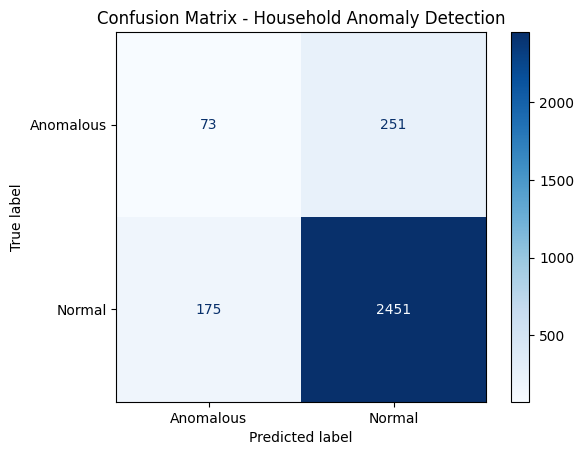

In [25]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import glob

# ======================================================
# 1️⃣ Load the ground truth anomalies (filtered_data)
# ======================================================
# Assuming filtered_data is already a DataFrame
true_anomalies = set(filtered_data['household_ID'].unique())
# ======================================================
# 4️⃣ Identify normal households (not in ground truth anomalies)
# ======================================================
normal_households = all_households - true_anomalies
# ======================================================
# 5️⃣ Build labels for confusion matrix
# ======================================================
y_true = []
y_pred = []

for hh in all_households:
    true_label = 1 if hh in true_anomalies else 0
    pred_label = 1 if hh in predicted_anomalies else 0
    y_true.append(true_label)
    y_pred.append(pred_label)


# ======================================================
# 6️⃣ Compute confusion matrix
# ======================================================
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

# Order: [[TP, FN], [FP, TN]]
tp, fn, fp, tn = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

print("✅ Confusion Matrix:")
print(pd.DataFrame(cm,
                   index=['Actual: Anomalous', 'Actual: Normal'],
                   columns=['Predicted: Anomalous', 'Predicted: Normal']))
print("\nMetrics Summary:")
print(f"True Positives (TP): {tp}")
print(f"False Negatives (FN): {fn}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")

# ======================================================
# 7️⃣ Visualize confusion matrix
# ======================================================
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Anomalous', 'Normal'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Household Anomaly Detection")
plt.show()


In [27]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    classification_report
)

# ======================================================
# 6️⃣.1 Compute full performance metrics
# ======================================================

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Classification report
report = classification_report(
    y_true,
    y_pred,
    target_names=["Normal", "Anomalous"],
    digits=3
)

# Print results
print("\n==================== METRICS SUMMARY ====================")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1 Score : {f1:.3f}")
print("==========================================================")
print("\nDetailed Classification Report:")
print(report)


==================== METRICS SUMMARY ====================
Accuracy : 0.856
Precision: 0.294
Recall   : 0.225
F1 Score : 0.255

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal      0.907     0.933     0.920      2626
   Anomalous      0.294     0.225     0.255       324

    accuracy                          0.856      2950
   macro avg      0.601     0.579     0.588      2950
weighted avg      0.840     0.856     0.847      2950



In [1]:
import pandas as pd

In [2]:
# -------------------------------
# 2️⃣ Load autoencoder CSVs (clusters 0-6) and concatenate
# -------------------------------
ae_dfs = []
for i in range(6):
    path = f'/home/ranushi/test/Anomaly DetectionMethod/anomalous_high_energy_households_cluster_2{i}.csv'
    df = pd.read_csv(path)
    df = df[['household_ID', 'cluster']]
    ae_dfs.append(df)

ae_df = pd.concat(ae_dfs, ignore_index=True)

In [3]:
appliance_age = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/wave_1/household_appliance_specifications_202509020921.csv')

/tmp/ipykernel_100677/2973607930.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  appliance_age = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/wave_1/household_appliance_specifications_202509020921.csv')


In [4]:
appliance_age = appliance_age[['household_id','appliance_name','no_of_appliances','purchased_time1',
                              'purchased_time2','purchased_time3','purchased_time4']]

In [5]:
df = appliance_age.copy()

In [6]:
import pandas as pd
import numpy as np

# Define order of appliance age (older = larger number)
age_order = {
    'Within the last 1 year': 1,
    'Within the last 1-5 years': 2,
    'Wthin the last 1-5 years': 2,     # fix typo version
    'Within the last 5-10 years': 3,
    'Wthin the last 5-10 years': 3,    # fix typo version
    'More than 10 years ago': 4
}

# Columns to check
purchased_cols = ['purchased_time1', 'purchased_time2', 'purchased_time3', 'purchased_time4']

# Convert categories to numeric according to hierarchy
df_numeric = df[purchased_cols].apply(lambda col: col.map(age_order))

# Find the oldest (maximum numeric value across columns)
df['appliance_age_code'] = df_numeric.max(axis=1, skipna=True)

# Map numeric code back to category name
reverse_age_order = {v: k for k, v in age_order.items()}
df['appliance_age'] = df['appliance_age_code'].map(reverse_age_order)

# Keep only the required columns
result = df[['household_id', 'appliance_name', 'appliance_age']].dropna(subset=['appliance_age']).reset_index(drop=True)

print(result.head())

  household_id   appliance_name              appliance_age
0       ID0430        Microwave     More than 10 years ago
1       ID0430      Rice cooker  Wthin the last 5-10 years
2       ID0430  Electric Kettle     More than 10 years ago
3       ID0528     Refrigerator     More than 10 years ago
4       ID0528      Rice cooker     Within the last 1 year


In [7]:
if not result.empty:
    def recode_age(age):
        """Simplify appliance age categories."""
        if age in ['More than 10 years ago', 'Unknown']:
            return 'Old'
        elif age in ['Within the last 1-5 years', 'Within the last 1 year']:
            return 'Recent'
        elif age in ['Within the last 5-10 years', 'Wthin the last 5-10 years']:
            return 'Middle'
        else:
            return 'Old'

    result['age_group'] = result['appliance_age'].apply(recode_age)
    print("\n✅ Appliance age groups recoded successfully.")
else:
    print("⚠️ No appliance data to recode.")


✅ Appliance age groups recoded successfully.


In [8]:
import pandas as pd

# Step 1: Define main appliances
main_appliances = [
    'Microwave',
    'Refrigerator',
    'Geyser / Hot water systems for bathrooms which operate from electricity',
    'Washing Machine',
    'Electric Oven',
    'Separate Freezer',
    'Air Conditioner',
    'Electric heater (to control room temperature)'
]

# Step 2: Filter only main appliances
filtered_df = result[result['appliance_name'].isin(main_appliances)].copy()

# Step 3: Check which households remain
if filtered_df.empty:
    print("⚠️ No main appliances found in the data.")
else:
    # Step 4: Count how many appliances fall under each age_group per household
    household_age_counts = (
        filtered_df.groupby(['household_id', 'age_group'])['appliance_name']
        .count()
        .reset_index(name='count')
    )

    # Step 5: Find the most common (mode) age group per household
    # If there are ties, this picks the first one alphabetically (you can change logic if needed)
    dominant_age = (
        household_age_counts.loc[
            household_age_counts.groupby('household_id')['count'].idxmax()
        ]
        .reset_index(drop=True)
    )

    # Step 6: Create the “most_...” column label
    dominant_age['dominant_category'] = 'most_' + dominant_age['age_group']

    # Step 7: Keep only household_id and dominant category
    household_dominant_age = dominant_age[['household_id', 'dominant_category']]

    print("\n✅ Dominant appliance age category computed successfully!\n")
    print(household_dominant_age.head())


✅ Dominant appliance age category computed successfully!

  household_id dominant_category
0       ID0001          most_Old
1       ID0002       most_Middle
2       ID0003       most_Middle
3       ID0005       most_Recent
4       ID0006       most_Middle


In [9]:
import pandas as pd
import os
import glob

# Directory path
dir_path = '/home/ranushi/test/Anomaly DetectionMethod/15min_interval'

# Get all CSV files in the directory
csv_files = glob.glob(os.path.join(dir_path, '*.csv'))

# List to store dataframes
dfs = []

# Read each CSV file
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all dataframes
combined_df = pd.concat(dfs, ignore_index=True)

# Calculate average powerfactor for each household
avg_powerfactor = combined_df.groupby('household_ID')['powerfactor'].mean().reset_index()
avg_powerfactor.columns = ['household_ID', 'average_powerfactor']

# Display the result
print(avg_powerfactor)

     household_ID  average_powerfactor
0          ID0013             0.754472
1          ID0018             0.205128
2          ID0041            -0.001664
3          ID0043             0.220554
4          ID0052             0.869455
...           ...                  ...
2933       ID5571             0.946570
2934       ID5572             0.121005
2935       ID5573             0.710816
2936       ID5574             0.553514
2937       ID5575             0.245074

[2938 rows x 2 columns]


In [10]:
age_powerfactor = pd.merge(household_dominant_age,avg_powerfactor, left_on='household_id', right_on='household_ID', how='inner')

In [11]:
filtered_data = age_powerfactor[
    (age_powerfactor['dominant_category'] == 'most_Old') & 
    (age_powerfactor['average_powerfactor'] < 0.75) &
    (age_powerfactor['average_powerfactor'].notna())
]

In [12]:
# Find intersection of household_IDs
common_households = set(filtered_data['household_id']).intersection(set(ae_df['household_ID']))

# Convert to DataFrame if you want to see or save it
intersection_df = pd.DataFrame({'household_ID': list(common_households)})

# Display results
print(f"Number of common households: {len(intersection_df)}")
print(intersection_df.head())

Number of common households: 25
  household_ID
0       ID2406
1       ID1031
2       ID3720
3       ID3282
4       ID3113


In [13]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import glob

# ======================================================
# 1️⃣ Load the ground truth anomalies (filtered_data)
# ======================================================
# Assuming filtered_data is already a DataFrame
true_anomalies = set(filtered_data['household_ID'].unique())

In [14]:
predicted_anomalies = set(ae_df['household_ID'].unique())

In [16]:
len(predicted_anomalies)

248

In [17]:
# ======================================================
# 3️⃣ Load all households from 6-hour interval files
# ======================================================
folder_path = '/home/ranushi/test/Anomaly DetectionMethod/6hour_interval'
all_files = glob.glob(os.path.join(folder_path, '*.csv'))

all_households = set()
for file in all_files:
    df = pd.read_csv(file)
    if 'household_ID' in df.columns:
        all_households.update(df['household_ID'].unique())
    else:
        print(f"⚠️ Skipping {file}, no 'household_ID' column found.")

# ======================================================
# 4️⃣ Identify normal households (not in ground truth anomalies)
# ======================================================
normal_households = all_households - true_anomalies

/tmp/ipykernel_100677/4074882391.py:9: DtypeWarning: Columns (9,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_100677/4074882391.py:9: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_100677/4074882391.py:9: DtypeWarning: Columns (14,25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_100677/4074882391.py:9: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


In [18]:
# ======================================================
# 5️⃣ Build labels for confusion matrix
# ======================================================
y_true = []
y_pred = []

for hh in all_households:
    true_label = 1 if hh in true_anomalies else 0
    pred_label = 1 if hh in predicted_anomalies else 0
    y_true.append(true_label)
    y_pred.append(pred_label)

✅ Confusion Matrix:
                   Predicted: Anomalous  Predicted: Normal
Actual: Anomalous                    25                 76
Actual: Normal                      223               2626

Metrics Summary:
True Positives (TP): 25
False Negatives (FN): 76
False Positives (FP): 223
True Negatives (TN): 2626


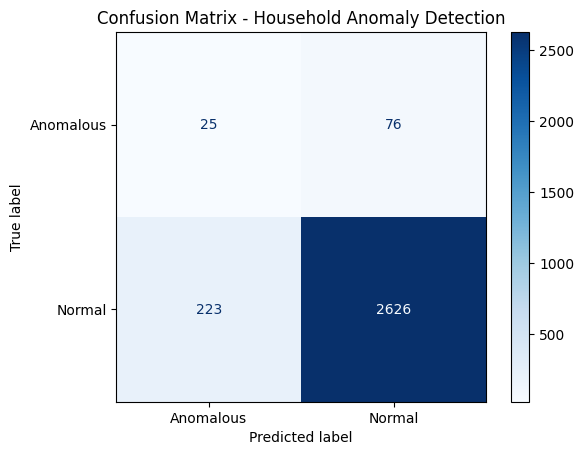

In [19]:

# ======================================================
# 6️⃣ Compute confusion matrix
# ======================================================
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

# Order: [[TP, FN], [FP, TN]]
tp, fn, fp, tn = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

print("✅ Confusion Matrix:")
print(pd.DataFrame(cm,
                   index=['Actual: Anomalous', 'Actual: Normal'],
                   columns=['Predicted: Anomalous', 'Predicted: Normal']))
print("\nMetrics Summary:")
print(f"True Positives (TP): {tp}")
print(f"False Negatives (FN): {fn}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")

# ======================================================
# 7️⃣ Visualize confusion matrix
# ======================================================
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Anomalous', 'Normal'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Household Anomaly Detection")
plt.show()

In [20]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    classification_report
)

# ======================================================
# 6️⃣.1 Compute full performance metrics
# ======================================================

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Classification report
report = classification_report(
    y_true,
    y_pred,
    target_names=["Normal", "Anomalous"],
    digits=3
)

# Print results
print("\n==================== METRICS SUMMARY ====================")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1 Score : {f1:.3f}")
print("==========================================================")
print("\nDetailed Classification Report:")
print(report)


==================== METRICS SUMMARY ====================
Accuracy : 0.899
Precision: 0.101
Recall   : 0.248
F1 Score : 0.143

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal      0.972     0.922     0.946      2849
   Anomalous      0.101     0.248     0.143       101

    accuracy                          0.899      2950
   macro avg      0.536     0.585     0.545      2950
weighted avg      0.942     0.899     0.919      2950



In [32]:
appliance_age = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/wave_1/household_appliance_specifications_202509020921.csv')

/tmp/ipykernel_100677/2973607930.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  appliance_age = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/wave_1/household_appliance_specifications_202509020921.csv')


In [33]:
appliance_age = appliance_age[['household_id','appliance_name','no_of_appliances','purchased_time1',
                              'purchased_time2','purchased_time3','purchased_time4']]

In [34]:
df = appliance_age.copy()

In [35]:
import pandas as pd
import numpy as np

# Define order of appliance age (older = larger number)
age_order = {
    'Within the last 1 year': 1,
    'Within the last 1-5 years': 2,
    'Wthin the last 1-5 years': 2,     # fix typo version
    'Within the last 5-10 years': 3,
    'Wthin the last 5-10 years': 3,    # fix typo version
    'More than 10 years ago': 4
}

# Columns to check
purchased_cols = ['purchased_time1', 'purchased_time2', 'purchased_time3', 'purchased_time4']

# Convert categories to numeric according to hierarchy
df_numeric = df[purchased_cols].apply(lambda col: col.map(age_order))

# Find the oldest (maximum numeric value across columns)
df['appliance_age_code'] = df_numeric.max(axis=1, skipna=True)

# Map numeric code back to category name
reverse_age_order = {v: k for k, v in age_order.items()}
df['appliance_age'] = df['appliance_age_code'].map(reverse_age_order)

# Keep only the required columns
result = df[['household_id', 'appliance_name', 'appliance_age']].dropna(subset=['appliance_age']).reset_index(drop=True)

print(result.head())

  household_id   appliance_name              appliance_age
0       ID0430        Microwave     More than 10 years ago
1       ID0430      Rice cooker  Wthin the last 5-10 years
2       ID0430  Electric Kettle     More than 10 years ago
3       ID0528     Refrigerator     More than 10 years ago
4       ID0528      Rice cooker     Within the last 1 year


In [36]:
if not result.empty:
    def recode_age(age):
        """Simplify appliance age categories."""
        if age in ['More than 10 years ago', 'Unknown']:
            return 'Old'
        elif age in ['Within the last 1-5 years', 'Within the last 1 year']:
            return 'Recent'
        elif age in ['Within the last 5-10 years', 'Wthin the last 5-10 years']:
            return 'Middle'
        else:
            return 'Old'

    result['age_group'] = result['appliance_age'].apply(recode_age)
    print("\n✅ Appliance age groups recoded successfully.")
else:
    print("⚠️ No appliance data to recode.")


✅ Appliance age groups recoded successfully.


In [37]:
import pandas as pd

# Step 1: Define main appliances
main_appliances = [
    'Microwave',
    'Refrigerator',
    'Geyser / Hot water systems for bathrooms which operate from electricity',
    'Washing Machine',
    'Electric Oven',
    'Separate Freezer',
    'Air Conditioner',
    'Electric heater (to control room temperature)'
]

# Step 2: Filter only main appliances
filtered_df = result[result['appliance_name'].isin(main_appliances)].copy()

# Step 3: Check which households remain
if filtered_df.empty:
    print("⚠️ No main appliances found in the data.")
else:
    # Step 4: Count how many appliances fall under each age_group per household
    household_age_counts = (
        filtered_df.groupby(['household_id', 'age_group'])['appliance_name']
        .count()
        .reset_index(name='count')
    )

    # Step 5: Find the most common (mode) age group per household
    # If there are ties, this picks the first one alphabetically (you can change logic if needed)
    dominant_age = (
        household_age_counts.loc[
            household_age_counts.groupby('household_id')['count'].idxmax()
        ]
        .reset_index(drop=True)
    )

    # Step 6: Create the “most_...” column label
    dominant_age['dominant_category'] = 'most_' + dominant_age['age_group']

    # Step 7: Keep only household_id and dominant category
    household_dominant_age = dominant_age[['household_id', 'dominant_category']]

    print("\n✅ Dominant appliance age category computed successfully!\n")
    print(household_dominant_age.head())


✅ Dominant appliance age category computed successfully!

  household_id dominant_category
0       ID0001          most_Old
1       ID0002       most_Middle
2       ID0003       most_Middle
3       ID0005       most_Recent
4       ID0006       most_Middle


In [38]:
import pandas as pd
import os
import glob

# Directory path
dir_path = '/home/ranushi/test/Anomaly DetectionMethod/15min_interval'

# Get all CSV files in the directory
csv_files = glob.glob(os.path.join(dir_path, '*.csv'))

# List to store dataframes
dfs = []

# Read each CSV file
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all dataframes
combined_df = pd.concat(dfs, ignore_index=True)

# Calculate average powerfactor for each household
avg_powerfactor = combined_df.groupby('household_ID')['powerfactor'].mean().reset_index()
avg_powerfactor.columns = ['household_ID', 'average_powerfactor']

# Display the result
print(avg_powerfactor)

# Optionally, save to CSV
# avg_powerfactor.to_csv('household_avg_powerfactor.csv', index=False)

     household_ID  average_powerfactor
0          ID0013             0.754472
1          ID0018             0.205128
2          ID0041            -0.001664
3          ID0043             0.220554
4          ID0052             0.869455
...           ...                  ...
2933       ID5571             0.946570
2934       ID5572             0.121005
2935       ID5573             0.710816
2936       ID5574             0.553514
2937       ID5575             0.245074

[2938 rows x 2 columns]


In [39]:
age_powerfactor = pd.merge(household_dominant_age,avg_powerfactor, left_on='household_id', right_on='household_ID', how='inner')

In [40]:
powerrrrr_data = age_powerfactor[
    (age_powerfactor['average_powerfactor'] < 0.75) &
    (age_powerfactor['average_powerfactor'].notna())
]

In [41]:
# Find intersection of household_IDs
common_households = set(powerrrrr_data['household_id']).intersection(set(ae_df['household_ID']))

# Convert to DataFrame if you want to see or save it
intersection_df = pd.DataFrame({'household_ID': list(common_households)})

# Display results
print(f"Number of common households: {len(intersection_df)}")
print(intersection_df.head())

# (Optional) Save to a CSV
# intersection_df.to_csv('/home/ranushi/test/Anomaly DetectionMethod/intersecting_households.csv', index=False)

Number of common households: 67
  household_ID
0       ID0999
1       ID2406
2       ID1031
3       ID2358
4       ID3774


/tmp/ipykernel_100677/929530813.py:28: DtypeWarning: Columns (9,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_100677/929530813.py:28: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_100677/929530813.py:28: DtypeWarning: Columns (14,25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_100677/929530813.py:28: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


✅ Confusion Matrix:
                   Predicted: Anomalous  Predicted: Normal
Actual: Anomalous                    67                207
Actual: Normal                      181               2495

Metrics Summary:
True Positives (TP): 67
False Negatives (FN): 207
False Positives (FP): 181
True Negatives (TN): 2495


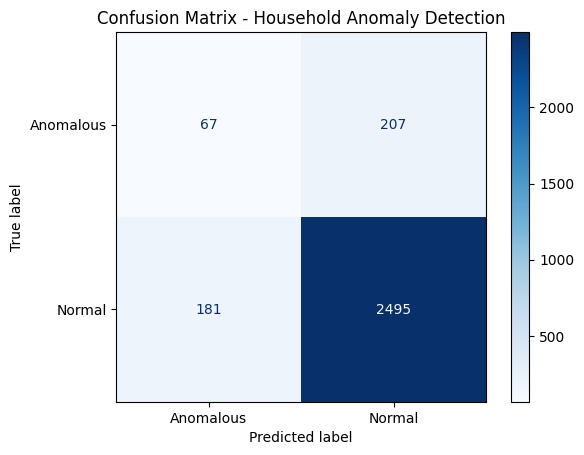

In [44]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import glob

# ======================================================
# 1️⃣ Load the ground truth anomalies (filtered_data)
# ======================================================
# Assuming filtered_data is already a DataFrame
true_anomalies = set(powerrrrr_data['household_ID'].unique())

# # ======================================================
# # 2️⃣ Load predicted anomalies
# # ======================================================
# similar_csv = '/home/ranushi/test/Anomaly DetectionMethod/similar_usage_high_energy_households3.csv'
# predicted_anomalies_df = pd.read_csv(similar_csv)
predicted_anomalies = set(ae_df['household_ID'].unique())

# ======================================================
# 3️⃣ Load all households from 6-hour interval files
# ======================================================
folder_path = '/home/ranushi/test/Anomaly DetectionMethod/6hour_interval'
all_files = glob.glob(os.path.join(folder_path, '*.csv'))

all_households = set()
for file in all_files:
    df = pd.read_csv(file)
    if 'household_ID' in df.columns:
        all_households.update(df['household_ID'].unique())
    else:
        print(f"⚠️ Skipping {file}, no 'household_ID' column found.")

# ======================================================
# 4️⃣ Identify normal households (not in ground truth anomalies)
# ======================================================
normal_households = all_households - true_anomalies

# ======================================================
# 5️⃣ Build labels for confusion matrix
# ======================================================
y_true = []
y_pred = []

for hh in all_households:
    true_label = 1 if hh in true_anomalies else 0
    pred_label = 1 if hh in predicted_anomalies else 0
    y_true.append(true_label)
    y_pred.append(pred_label)

# ======================================================
# 6️⃣ Compute confusion matrix
# ======================================================
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

# Order: [[TP, FN], [FP, TN]]
tp, fn, fp, tn = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

print("✅ Confusion Matrix:")
print(pd.DataFrame(cm,
                   index=['Actual: Anomalous', 'Actual: Normal'],
                   columns=['Predicted: Anomalous', 'Predicted: Normal']))
print("\nMetrics Summary:")
print(f"True Positives (TP): {tp}")
print(f"False Negatives (FN): {fn}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")

# ======================================================
# 7️⃣ Visualize confusion matrix
# ======================================================
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Anomalous', 'Normal'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Household Anomaly Detection")
plt.show()

In [45]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    classification_report
)

# ======================================================
# 6️⃣.1 Compute full performance metrics
# ======================================================

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Classification report
report = classification_report(
    y_true,
    y_pred,
    target_names=["Normal", "Anomalous"],
    digits=3
)

# Print results
print("\n==================== METRICS SUMMARY ====================")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1 Score : {f1:.3f}")
print("==========================================================")
print("\nDetailed Classification Report:")
print(report)


==================== METRICS SUMMARY ====================
Accuracy : 0.868
Precision: 0.270
Recall   : 0.245
F1 Score : 0.257

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal      0.923     0.932     0.928      2676
   Anomalous      0.270     0.245     0.257       274

    accuracy                          0.868      2950
   macro avg      0.597     0.588     0.592      2950
weighted avg      0.863     0.868     0.866      2950

